In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, division
import os, sys
import h5py
import numpy as np
import pandas as pd
from sklearn import decomposition, manifold

%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='whitegrid')

In [3]:
import plots
import gctx_utils

In [4]:
gctx3 = h5py.File('data/GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx', 'r')

Data files were downloaded from GEO study [GSE92742](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742)

In [5]:
!ls -lht data/

total 83G
-rw-r--r-- 1 root root 565K Nov 27 21:55 parsed_Repurposing_Hub.csv
-rw-r--r-- 1 root root 1.4M Nov 27 21:03 Repurposing_Hub_export_2018.txt
drwxr-xr-x 5 root root  170 Nov 27 20:43 results
-rw-r--r-- 1 root root  61G Nov 19 20:00 GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx
-rw-r--r-- 1 root root  22G Nov 19 15:54 GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx
-rw-r--r-- 1 root root  12M Nov 19 15:48 GSE92742_Broad_LINCS_sig_metrics.txt.gz
-rw-r--r-- 1 root root  11M Nov 19 15:48 GSE92742_Broad_LINCS_sig_info.txt.gz
-rw-r--r-- 1 root root 1.1M Nov 19 15:48 GSE92742_Broad_LINCS_pert_info.txt.gz
-rw-r--r-- 1 root root  12M Nov 19 15:47 GSE92742_Broad_LINCS_inst_info.txt.gz
-rw-r--r-- 1 root root 212K Nov 19 15:47 GSE92742_Broad_LINCS_gene_info.txt.gz


Parse metadata of genes and instances

In [6]:
gene_info_df = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt.gz', 
                           compression='gzip',
                          sep='\t')
gene_info_df.set_index(gene_info_df.columns[0], inplace=True)
gene_info_df.index = gene_info_df.index.astype(str)
print(gene_info_df.shape)
gene_info_df.head()

(12328, 4)


,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
pr_gene_id,,,,
780,DDR1,discoidin domain receptor tyrosine kinase 1,1,1
7849,PAX8,paired box 8,1,1
2978,GUCA1A,guanylate cyclase activator 1A,0,0
2049,EPHB3,EPH receptor B3,0,1
2101,ESRRA,estrogen related receptor alpha,0,1


In [7]:
LM_GENE_IDS = gene_info_df.query('pr_is_lm == 1').index
print(len(LM_GENE_IDS))

978


In [8]:
inst_info_df = pd.read_csv('data/GSE92742_Broad_LINCS_inst_info.txt.gz', 
                          compression='gzip',
                          sep='\t')
inst_info_df.set_index(inst_info_df.columns[0], inplace=True)
print(inst_info_df.shape)
inst_info_df.head()

(1319138, 10)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,rna_plate,rna_well,pert_id,pert_iname,pert_type,pert_dose,pert_dose_unit,pert_time,pert_time_unit,cell_id
inst_id,,,,,,,,,,
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:F13,ASG001_MCF7_24H_X1,F13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:G13,ASG001_MCF7_24H_X1,G13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:I13,ASG001_MCF7_24H_X1,I13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:K13,ASG001_MCF7_24H_X1,K13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:N13,ASG001_MCF7_24H_X1,N13,DMSO,DMSO,ctl_vehicle,0.1,%,24,h,MCF7


In [9]:
inst_info_df['pert_type'].value_counts()

trt_cp         672128
trt_sh         448737
trt_oe          87765
ctl_vector      30400
ctl_vehicle     28463
trt_lig         25739
ctl_untrt       22072
trt_oe.mut       3834
Name: pert_type, dtype: int64

Select compount treatment (`trt_cp`) and their controls (`ctr_vehicle`)

In [10]:
inst_info_df = inst_info_df.loc[inst_info_df['pert_type'].isin(['trt_cp', 'ctl_vehicle'])]
print(inst_info_df.shape)

(700591, 10)


In [11]:
# Find the top cell lines
inst_info_df['cell_id'].value_counts()

VCAP        125539
MCF7        103448
PC3          96014
A549         60622
A375         54971
HT29         53436
HA1E         32613
HCC515       27449
HEPG2        19019
NPC          15060
NEU           9452
ASC           9124
SKB           7863
PHH           7068
SKBR3         5410
BT20          5108
MDAMB231      5094
MCF10A        4626
HS578T        4367
FIBRNPC       3623
NKDBA         2897
HEK293T       2322
THP1          2193
NOMO1         2122
JURKAT        2104
U266          2097
HL60          2052
HUH7          1728
U937          1701
SW948         1421
             ...  
EFO27          741
HCT116         740
LOVO           739
AGS            738
NCIH596        738
SNUC4          737
RKO            732
DV90           730
JHUEM2         729
H1299          729
OV7            728
WSUDLCL2       727
SKLU1          726
SKMEL28        725
PL21           724
RMGI           723
SNGM           719
CORL23         718
NCIH508        705
TYKNU          697
CL34           688
HT115       

In [12]:
# Only examine samples from PC3 cell line
inst_info_df = inst_info_df.query('cell_id == "PC3"')
# inst_info_df = inst_info_df.query('cell_id == "NPC"')
inst_info_df.shape

(96014, 10)

In [13]:
inst_info_df.pert_type.value_counts()

trt_cp         91954
ctl_vehicle     4060
Name: pert_type, dtype: int64

In [14]:
inst_info_df.rna_plate.value_counts()

PCLB001_PC3_24H_X1      1055
CPC009_PC3_6H_X3         736
CPC006_PC3_24H_X2        731
CPC019_PC3_24H_X1        728
CPC001_PC3_24H_X3        721
ERG015_PC3_6H_X3         377
CPC009_PC3_24H_X1        377
CPC020_PC3_6H_X3         376
CPC006_PC3_6H_X4         376
CPC003_PC3_24H_X2        375
CPC011_PC3_6H_X5         375
CPC012_PC3_24H_X1        375
ERG014_PC3_24H_X2        375
CPC001_PC3_24H_X4        375
CPC011_PC3_6H_X4         375
CPC006_PC3_6H_X3         375
CPC020_PC3_6H_X1         375
PCLB002_PC3_24H_X2       375
CPC008_PC3_6H_X2         375
CPC004_PC3_6H_X4         375
PCLB003_PC3_24H_X1       375
CPC008_PC3_6H_X4         374
CPC010_PC3_24H_X3        374
PCLB002_PC3_24H_X1       374
CPC013_PC3_6H_X3         374
PCLB003_PC3_24H_X2       374
CPC011_PC3_24H_X4        374
CPD002_PC3_6H_X1         374
CPC007_PC3_6H_X5         374
CPC010_PC3_6H_X4         374
                        ... 
DEB001_PC3_6H_X4         328
DOS056_PC3_24H_X1        327
ERG012_PC3_6H_X2         327
DOS032_PC3_24H

In [15]:
inst_info_df.query('pert_type =="ctl_vehicle"')['rna_plate'].value_counts()

DEB001_PC3_6H_X2.A2     36
PRISM001_PC3_24H_X1     36
RAD001_PC3_6H_X2        36
PRISM001_PC3_6H_X1      34
ERG015_PC3_6H_X1        32
ERG014_PC3_24H_X2       32
ERG014_PC3_24H_X3       32
DEB001_PC3_24H_X2       32
ERG015_PC3_6H_X3        32
DEB001_PC3_24H_X1.A2    31
ERG014_PC3_6H_X3        31
ERG015_PC3_6H_X2        31
CYT001_PC3_2H_X2        31
ERG014_PC3_24H_X1       31
HDAC001_PC3_24H_X1      30
HDAC001_PC3_24H_X3      29
HDAC001_PC3_6H_X2       29
DEB001_PC3_6H_X4        28
RAD001_PC3_6H_X1        28
DOS047_PC3_24H_X3       28
HDAC001_PC3_24H_X2      28
ERG014_PC3_6H_X1        28
ASG001_PC3_24H_X5       27
RAD001_PC3_24H_X3       27
HDAC001_PC3_6H_X1       26
DOS034_PC3_24H_X1       26
DEB001_PC3_24H_X4       26
DEB001_PC3_6H_X1        26
HDAC001_PC3_6H_X3       26
DOSBIO002_PC3_24H_X2    25
                        ..
CPD002_PC3_24H_X3        8
CPC012_PC3_24H_X5.L2     8
CPC013_PC3_24H_X1        8
CPC020_PC3_6H_X5         8
CPC004_PC3_24H_X1        8
CPC004_PC3_24H_X2        8
C

In [16]:
# Extract batch and det_plate from the instance_id
inst_info_df['batch'] = inst_info_df['rna_plate'].map(lambda x: '_'.join(x.split('_')[:3]))
inst_info_df['det_plate'] = inst_info_df.index.map(lambda x: x.split(':')[0])

In [17]:
inst_ids_pclb = inst_info_df.loc[inst_info_df['batch'].isin(['CPC001_PC3_24H', 'CPC006_PC3_24H'])]
# inst_ids_pclb = inst_info_df.loc[inst_info_df['batch'].isin(['CPC018_NPC_24H', 'CPC012_NPC_24H'])]
inst_ids_pclb.shape

(4389, 12)

In [18]:
inst_ids_pclb['rna_plate'].value_counts()

CPC006_PC3_24H_X2    731
CPC001_PC3_24H_X3    721
CPC001_PC3_24H_X4    375
CPC001_PC3_24H_X2    368
CPC001_PC3_24H_X5    368
CPC006_PC3_24H_X5    367
CPC006_PC3_24H_X3    367
CPC006_PC3_24H_X1    366
CPC001_PC3_24H_X1    363
CPC006_PC3_24H_X4    363
Name: rna_plate, dtype: int64

In [19]:
inst_ids_pclb['det_plate'].value_counts()

CPC001_PC3_24H_X4_F2B4_DUO52HI53LO    375
CPC001_PC3_24H_X5_B5_DUO52HI53LO      368
CPC001_PC3_24H_X2_B3_DUO52HI53LO      368
CPC001_PC3_24H_X3_F1B3_DUO52HI53LO    367
CPC006_PC3_24H_X5_B4_DUO52HI53LO      367
CPC006_PC3_24H_X3_F1B3_DUO52HI53LO    367
CPC006_PC3_24H_X1_B4_DUO52HI53LO      366
CPC006_PC3_24H_X2_B4_DUO52HI53LO      366
CPC006_PC3_24H_X2_F1B3_DUO52HI53LO    365
CPC006_PC3_24H_X4_B4_DUO52HI53LO      363
CPC001_PC3_24H_X1_B3_DUO52HI53LO      363
CPC001_PC3_24H_X3_B3_DUO52HI53LO      354
Name: det_plate, dtype: int64

## Different levels of batch effects (batch, rna_plate, det_plate) 

In [20]:
# Retrieve the slice of the expression matrix from the gctx file
mat = gctx_utils.slice_matrix(gctx3,
                   rids=LM_GENE_IDS,
                   cids=inst_ids_pclb.index
                   )
mat.shape

(4389, 978)

In [21]:
inst_ids_pclb['pert_type'].value_counts()

trt_cp         4251
ctl_vehicle     138
Name: pert_type, dtype: int64

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


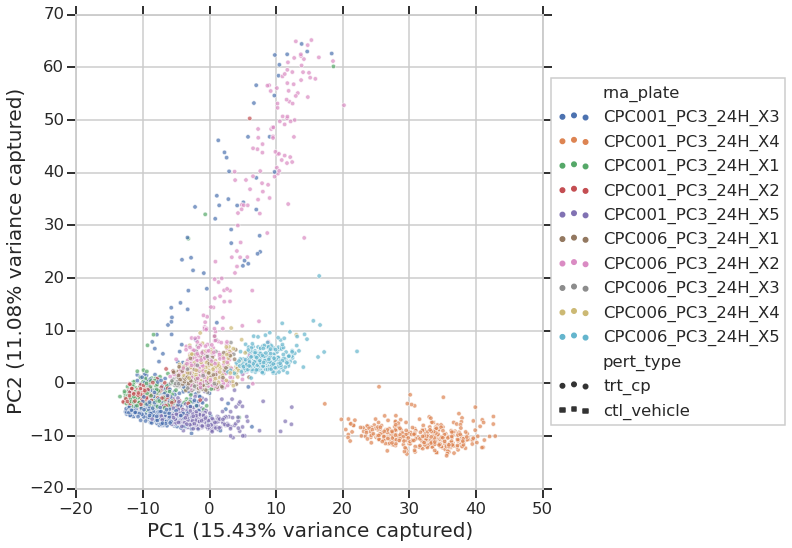

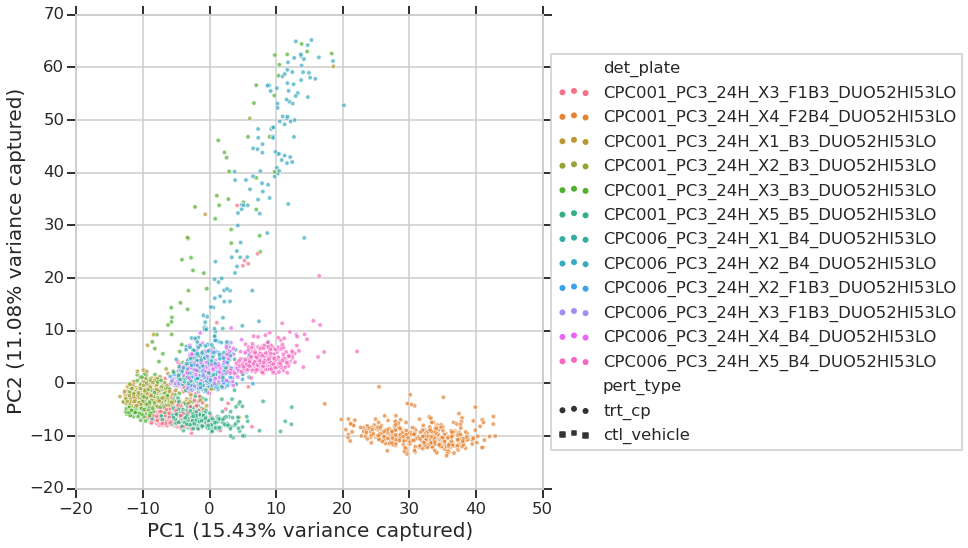

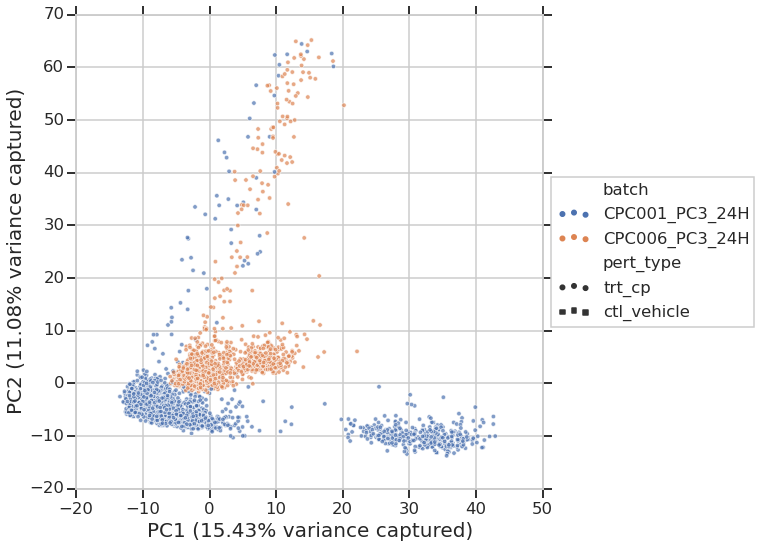

In [22]:
fig = plots.PCA_plot(mat.T, inst_ids_pclb, hue='rna_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat.T, inst_ids_pclb, hue='det_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat.T, inst_ids_pclb, hue='batch', style='pert_type', standardize=3)

In [23]:
mat_centered_by_rna = gctx_utils.mean_center(mat, inst_ids_pclb['rna_plate'])

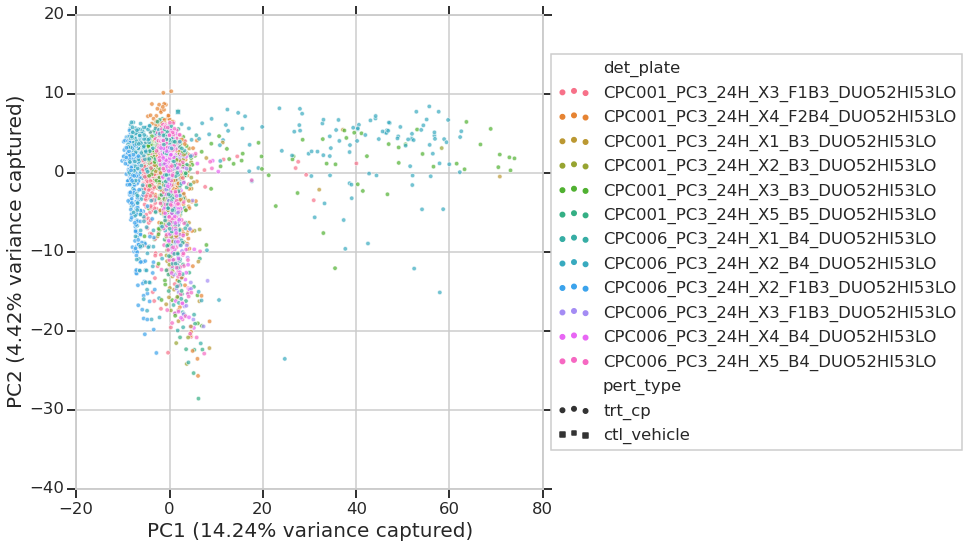

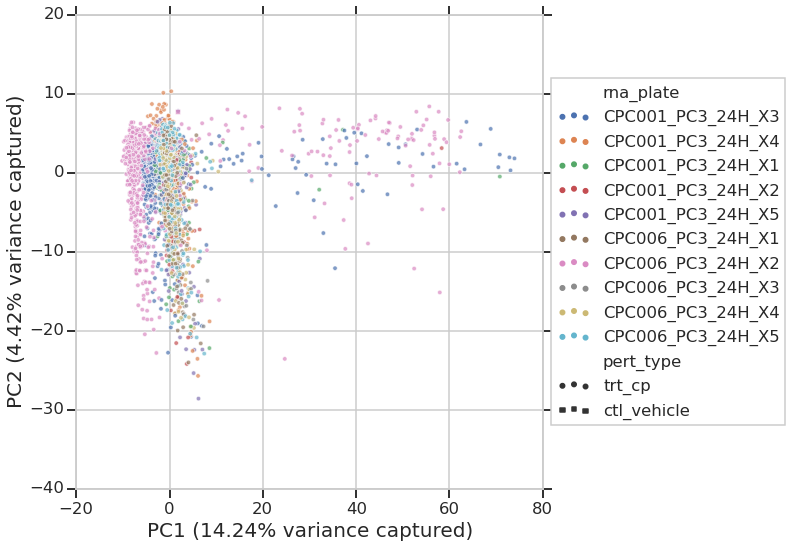

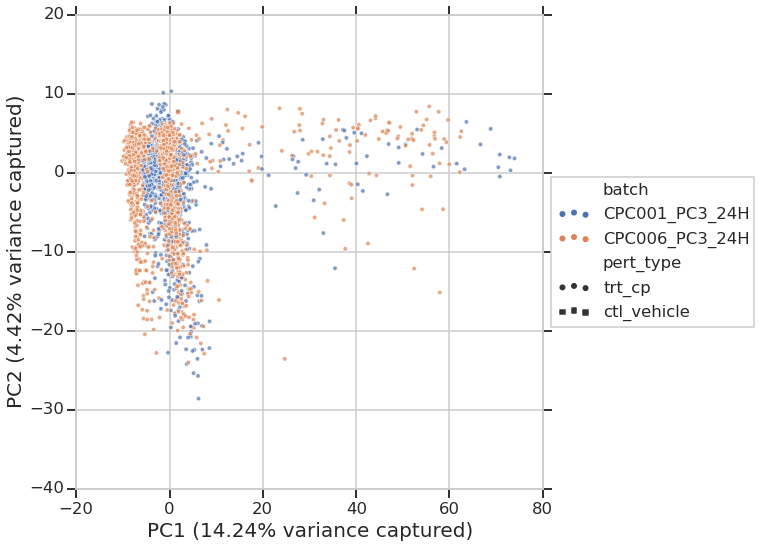

In [24]:
fig = plots.PCA_plot(mat_centered_by_rna.T, inst_ids_pclb, hue='det_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_rna.T, inst_ids_pclb, hue='rna_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_rna.T, inst_ids_pclb, hue='batch', style='pert_type', standardize=3)

In [25]:
mat_centered_by_det = gctx_utils.mean_center(mat, inst_ids_pclb['det_plate'])

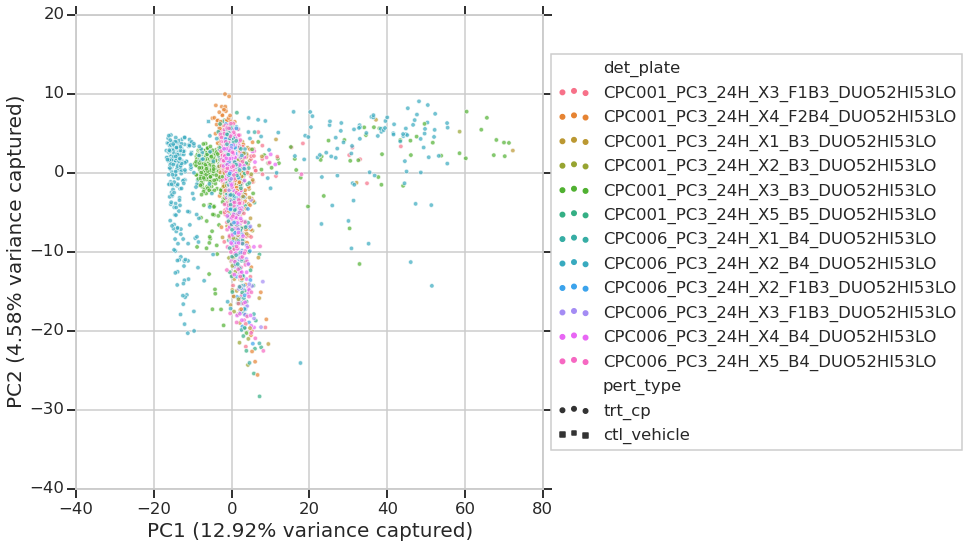

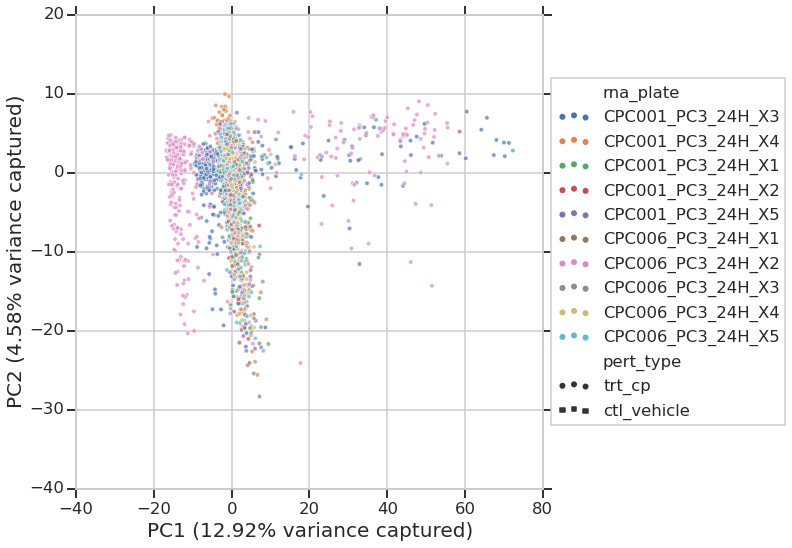

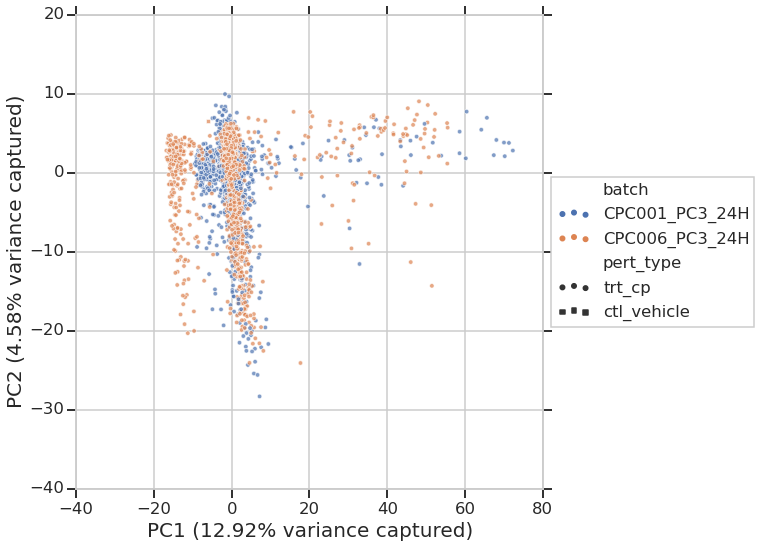

In [26]:
fig = plots.PCA_plot(mat_centered_by_det.T, inst_ids_pclb, hue='det_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_det.T, inst_ids_pclb, hue='rna_plate', style='pert_type', standardize=3)
fig = plots.PCA_plot(mat_centered_by_det.T, inst_ids_pclb, hue='batch', style='pert_type', standardize=3)

## Load sig_info to compute signatures

In [27]:
sig_info_df = pd.read_csv('data/GSE92742_Broad_LINCS_sig_info.txt.gz', 
                          compression='gzip',
                          sep='\t')
sig_info_df = sig_info_df.set_index('sig_id')
sig_info_df.shape

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(473647, 11)

In [28]:
sig_info_df.head()

,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id
sig_id,,,,,,,,,,,
AML001_CD34_24H:A05,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:A05
AML001_CD34_24H:A06,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:A06
AML001_CD34_24H:B05,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:B05|AML001_CD34_24H_X...
AML001_CD34_24H:B06,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:B06
AML001_CD34_24H:BRD-A03772856:0.37037,BRD-A03772856,BRD-A03772856,trt_cp,CD34,0.37037,µM,500 nM,24,h,24 h,AML001_CD34_24H_X1_F1B10:J04|AML001_CD34_24H_X...


In [29]:
sig_info_df = sig_info_df.query('cell_id == "PC3" & pert_type == "trt_cp"')
# sig_info_df = sig_info_df.query('cell_id == "NPC" & pert_type == "trt_cp"')
print(sig_info_df.shape)
sig_info_df.head()

(23123, 11)


,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id
sig_id,,,,,,,,,,,
AML001_PC3_6H:BRD-A03772856:0.37037,BRD-A03772856,BRD-A03772856,trt_cp,PC3,0.37037,µM,500 nM,6,h,6 h,AML001_PC3_6H_X1_F1B10:J16|AML001_PC3_6H_X2_F1...
AML001_PC3_6H:BRD-A03772856:1.11111,BRD-A03772856,BRD-A03772856,trt_cp,PC3,1.11111,µM,1 µM,6,h,6 h,AML001_PC3_6H_X1_F1B10:J15|AML001_PC3_6H_X2_F1...
AML001_PC3_6H:BRD-A03772856:10,BRD-A03772856,BRD-A03772856,trt_cp,PC3,10,µM,10 µM,6,h,6 h,AML001_PC3_6H_X1_F1B10:I15|AML001_PC3_6H_X2_F1...
AML001_PC3_6H:BRD-A03772856:3.33333,BRD-A03772856,BRD-A03772856,trt_cp,PC3,3.33333,µM,3 µM,6,h,6 h,AML001_PC3_6H_X1_F1B10:I16|AML001_PC3_6H_X2_F1...
AML001_PC3_6H:BRD-A19037878:0.37037,BRD-A19037878,trichostatin-a,trt_cp,PC3,0.37037,µM,500 nM,6,h,6 h,AML001_PC3_6H_X1_F1B10:F18|AML001_PC3_6H_X2_F1...


In [30]:
pert_info_df = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt.gz', 
                          compression='gzip',
                          sep='\t')
pert_info_df = pert_info_df.set_index('pert_id')
pert_info_df = pert_info_df.query('pert_type == "trt_cp"').drop('pert_type', axis=1)
pert_info_df.shape

(20413, 6)

In [31]:
pert_info_df.columns

Index([u'pert_iname', u'is_touchstone', u'inchi_key_prefix', u'inchi_key',
       u'canonical_smiles', u'pubchem_cid'],
      dtype='object')

In [32]:
sig_info_df['batch'] = sig_info_df.index.map(lambda x: x.split(':')[0])
sig_info_df['n_distil_ids'] = sig_info_df['distil_id'].map(lambda x: len(x.split('|')))
# sig_info_df = sig_info_df.merge(pert_info_df, left_on='pert_id', right_index=True, how='left')

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1487: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


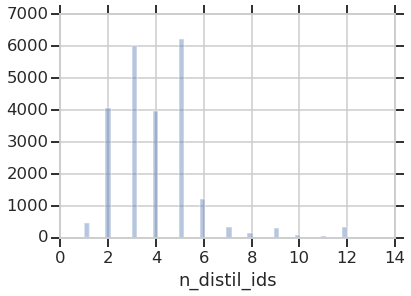

In [33]:
sns.distplot(sig_info_df['n_distil_ids'], kde=False)

In [34]:
# remove signatures with only one distil_id
sig_info_df = sig_info_df.query('n_distil_ids > 1')
sig_info_df.shape

(22664, 13)

In [35]:
sig_info_df.head()

,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id,batch,n_distil_ids
sig_id,,,,,,,,,,,,,
AML001_PC3_6H:BRD-A03772856:0.37037,BRD-A03772856,BRD-A03772856,trt_cp,PC3,0.37037,µM,500 nM,6,h,6 h,AML001_PC3_6H_X1_F1B10:J16|AML001_PC3_6H_X2_F1...,AML001_PC3_6H,3
AML001_PC3_6H:BRD-A03772856:1.11111,BRD-A03772856,BRD-A03772856,trt_cp,PC3,1.11111,µM,1 µM,6,h,6 h,AML001_PC3_6H_X1_F1B10:J15|AML001_PC3_6H_X2_F1...,AML001_PC3_6H,3
AML001_PC3_6H:BRD-A03772856:10,BRD-A03772856,BRD-A03772856,trt_cp,PC3,10,µM,10 µM,6,h,6 h,AML001_PC3_6H_X1_F1B10:I15|AML001_PC3_6H_X2_F1...,AML001_PC3_6H,3
AML001_PC3_6H:BRD-A03772856:3.33333,BRD-A03772856,BRD-A03772856,trt_cp,PC3,3.33333,µM,3 µM,6,h,6 h,AML001_PC3_6H_X1_F1B10:I16|AML001_PC3_6H_X2_F1...,AML001_PC3_6H,3
AML001_PC3_6H:BRD-A19037878:0.37037,BRD-A19037878,trichostatin-a,trt_cp,PC3,0.37037,µM,500 nM,6,h,6 h,AML001_PC3_6H_X1_F1B10:F18|AML001_PC3_6H_X2_F1...,AML001_PC3_6H,3


In [36]:
sig_info_df['pert_id'].value_counts().head(10)

BRD-K81418486    173
BRD-A75409952    122
BRD-A19037878    121
BRD-A19500257    121
BRD-K27305650     49
BRD-A90490067     42
BRD-K02130563     37
BRD-A13084692     33
BRD-K88742110     32
BRD-K64024097     32
Name: pert_id, dtype: int64

In [48]:
sig_info_df.shape

(22664, 13)

In [37]:
sig_info_df['pert_iname'].value_counts().head(10)

[autoreload of scipy.stats._discrete_distns failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name entr
]
[autoreload of scipy.stats.morestats failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name _contains_nan
]
[autoreload of scipy.optimize._minimize failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: BLAS function dsyr could not be found
]
[autoreload of scipy.spatial.distance failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, 

vorinostat        173
wortmannin        126
trichostatin-a    125
geldanamycin      121
LY-294002          49
fulvestrant        49
panobinostat       37
sirolimus          35
troglitazone       33
BRD-K64024097      32
Name: pert_iname, dtype: int64

In [38]:
sig_info_df_sub = sig_info_df.loc[sig_info_df['pert_id'].isin(
        ['BRD-K81418486', 'BRD-A75409952', 'BRD-A19037878', 'BRD-A19500257'])]
sig_info_df_sub.shape

(537, 13)

## Benchmark batch effect in level5 data (signatures)

In [39]:
gctx5 = h5py.File('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', 'r')

In [40]:
mat5 = gctx_utils.slice_matrix(gctx5, rids=LM_GENE_IDS, cids=sig_info_df_sub.index)
mat5.shape

(537, 978)

In [63]:
import h5py
import numpy as np
def slice_matrix(gctx, cids, rids, transpose=False):
    '''Slice the mat by cids and rids and ensure the mat 
    is ordered by cids and rids.'''    
    all_cids = gctx['/0/META/COL/id']
    c_mask = np.in1d(all_cids, cids)
    cids_subset = all_cids[c_mask].tolist()
    c_indices = np.array([cids_subset.index(id_) 
                          for id_ in cids])

    mat = gctx['/0/DATA/0/matrix']
    if not transpose:
        submat = mat[c_mask, :][c_indices, :]
    else:
        submat = mat[:, c_mask][:, c_indices]
    
    all_rids = gctx['/0/META/ROW/id']
    r_mask = np.in1d(all_rids, rids)
    rids_subset = all_rids[r_mask].tolist()
    r_indices = np.array([rids_subset.index(id_) 
                          for id_ in rids])
    if not transpose:
        submat = submat[:, r_mask][:, r_indices]
    else:
        submat = submat[r_mask, :][r_indices, :].T
    return submat

In [64]:
# Load level5 data from CD pipelines with and without batch effect corrections
gctx5_cd_center = h5py.File('data/results/CD_center_level5_PC3_n978x22664.gctx', 'r')
gctx5_cd_nocenter = h5py.File('data/results/CD_noncenter_level5_PC3_n978x22664.gctx', 'r')
gctx5_avg_center = h5py.File('data/results/Avg_center_level5_PC3_n978x22664.gctx', 'r')

mat5_cd_center = slice_matrix(gctx5_cd_center, rids=LM_GENE_IDS, cids=sig_info_df_sub.index, transpose=True)
mat5_cd_nocenter = slice_matrix(gctx5_cd_nocenter, rids=LM_GENE_IDS, cids=sig_info_df_sub.index, transpose=True)
mat5_avg_center = slice_matrix(gctx5_avg_center, rids=LM_GENE_IDS, cids=sig_info_df_sub.index, transpose=True)
print(mat5_cd_center.shape, mat5_cd_nocenter.shape, mat5_avg_center.shape)

(537, 978) (537, 978) (537, 978)


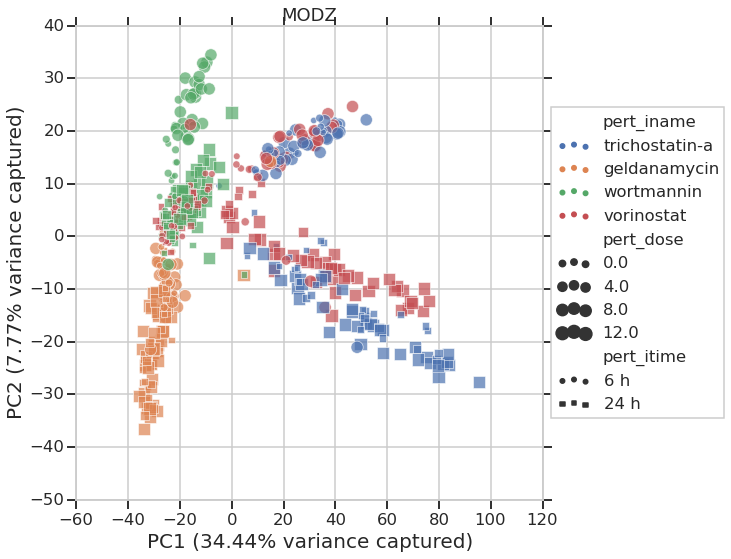

In [70]:
fig = plots.PCA_plot(mat5.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='pert_dose',
                     standardize=3)
fig.get_axes()[0].set_title('MODZ')

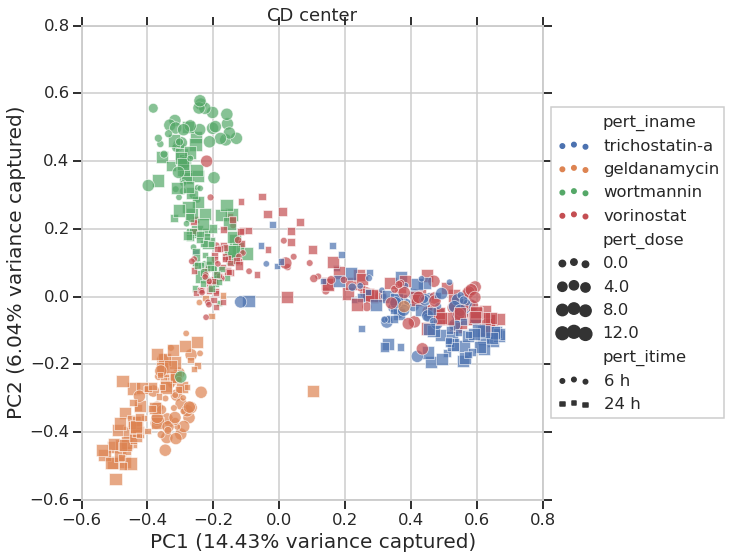

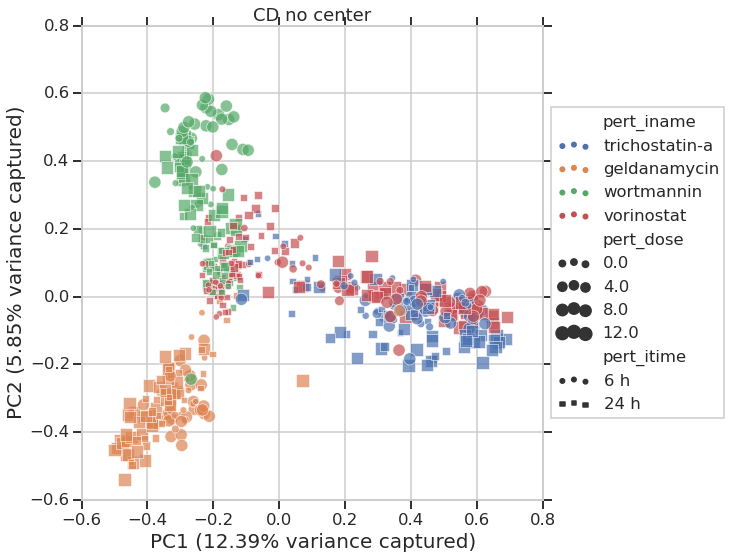

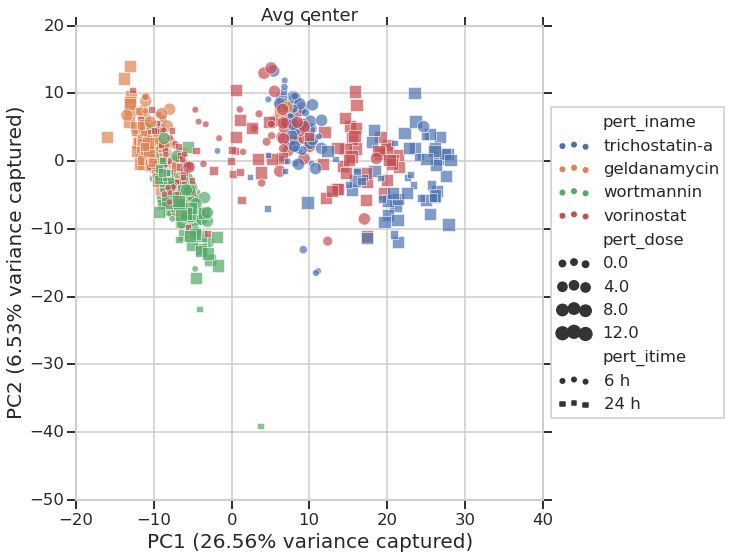

In [71]:
fig = plots.PCA_plot(mat5_cd_center.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='pert_dose',
                     standardize=3)
fig.get_axes()[0].set_title('CD center');

fig = plots.PCA_plot(mat5_cd_nocenter.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='pert_dose',
                     standardize=3)
fig.get_axes()[0].set_title('CD no center');

fig = plots.PCA_plot(mat5_avg_center.T, sig_info_df_sub, hue='pert_iname', style='pert_itime', 
                     size='pert_dose',
                     standardize=3)
fig.get_axes()[0].set_title('Avg center');

In [72]:
sig_info_df_sub['batch_prefix'] = sig_info_df_sub['batch'].map(lambda x:x.split('_')[0])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [73]:
sig_info_df_sub['batch'].nunique()

73

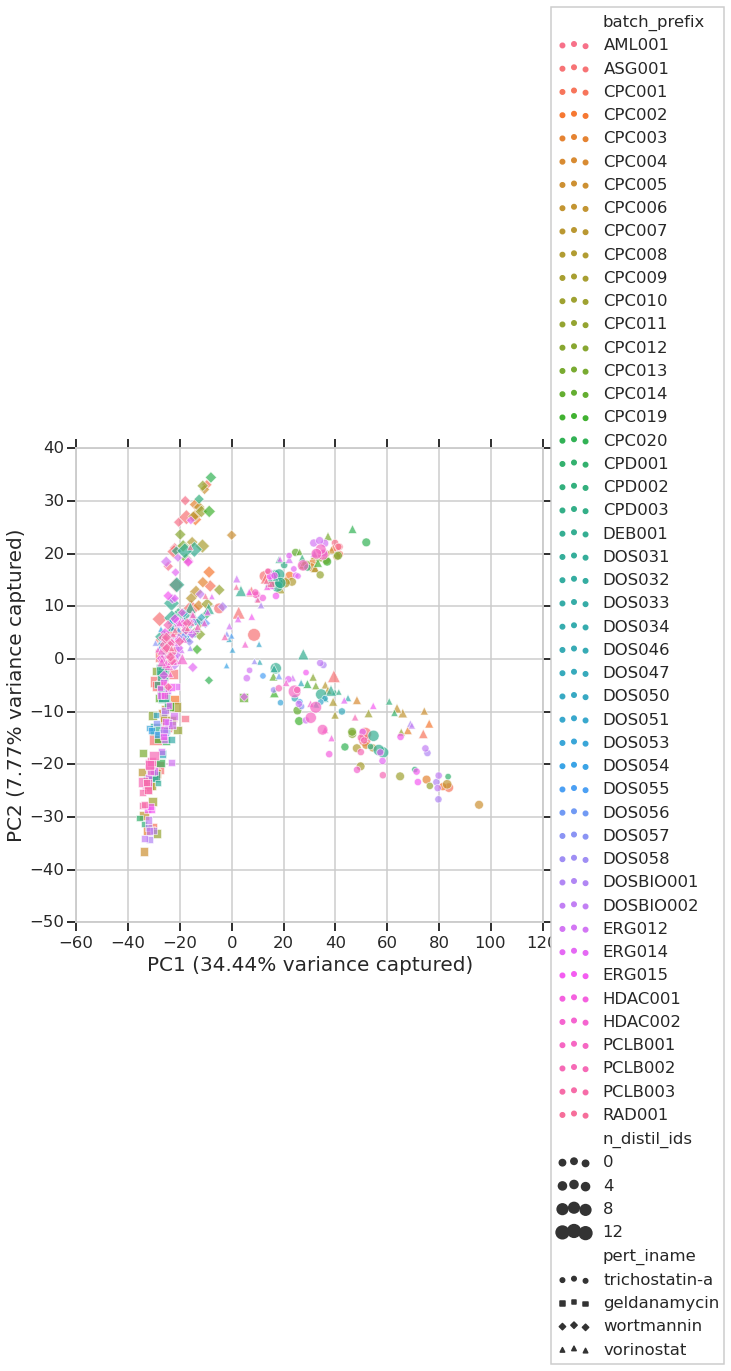

In [74]:
fig = plots.PCA_plot(mat5.T, sig_info_df_sub, hue='batch_prefix', style='pert_iname', 
                     size='n_distil_ids',
                     standardize=3)

In [75]:
import benchmarks

ImportError: cannot import name stats

In [47]:
res_scores = benchmarks.compute_pairwise_connectivity_scores(mat5, sig_info_df_sub, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0126s.) Setting batch_size=30.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0328s.) Setting batch_size=366.
[Parallel(n_jobs=6)]: Done 252 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 3160 out of 3160 | elapsed:    1.9s finished
[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0062s.) Setting batch_size=64.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  76 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Batch computation too fast (0.0756s.) Setting batch_size=

(71, 699, 316, 2074)


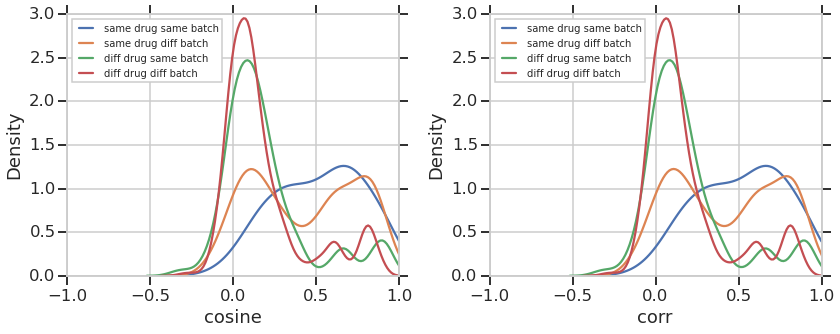

In [48]:
fig = benchmarks.density_plot_scores(res_scores, sig_info_df_sub)

(54, 716, 272, 2118)


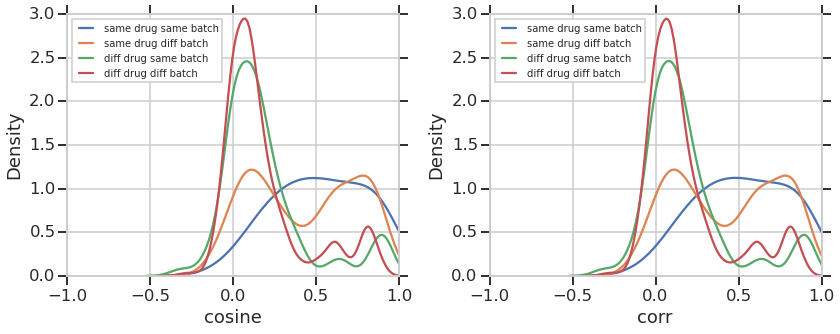

In [49]:
fig = benchmarks.density_plot_scores(res_scores, sig_info_df_sub, batch='batch')

## Visualizing the signatures

In [50]:
# Load data downloaded from RepurposingHub
drug_moa_df = pd.read_csv('data/Repurposing_Hub_export_2018.txt', sep='\t')
print(drug_moa_df.shape)
drug_moa_df['pert_ids'] = drug_moa_df['Id']\
    .map(lambda x: ','.join(set(['-'.join(item.split('-')[0:2]) for item in x.split(', ')])))

drug_moa_df['pert_id_count'] = drug_moa_df['pert_ids']\
    .map(lambda x: len(x.split(',')))

drug_moa_df.set_index('Name', inplace=True, verify_integrity=True)

(5628, 9)


In [51]:
# A dict from pert_id to name
d_pert_name = {}
for name, row in drug_moa_df.iterrows():
    for pert_id in row['pert_ids'].split(','):
        d_pert_name[pert_id] = name
len(d_pert_name)

6172

In [52]:
df_pert_name = pd.DataFrame({'pert_id': d_pert_name.keys(), 'Name': d_pert_name.values()})\
    .set_index('pert_id')
df_pert_name.head()

,Name
pert_id,
BRD-K15916496,clotrimazole
BRD-K84459715,zopolrestat
BRD-K32289541,EHop-016
BRD-A55312468,k-strophanthidin
BRD-K64874225,NSC-4644


In [53]:
drug_moa_df = df_pert_name.merge(drug_moa_df[['MOA', 'Target', 'Indication', 'Phase']], 
                                 left_on='Name', 
                                 right_index=True
                                )

In [54]:
drug_moa_df.shape

(6172, 5)

In [55]:
drug_moa_df.head()

,Name,MOA,Target,Indication,Phase
pert_id,,,,,
BRD-K15916496,clotrimazole,"cytochrome P450 inhibitor, imidazoline recepto...","CYP3A4, KCNN4, NR1I2, NR1I3, TRPM2, TRPM4, TRPM8","vulvovaginal candidiasis, oropharyngeal candid...",Launched
BRD-K84459715,zopolrestat,NaN,NaN,NaN,Phase 2
BRD-K32289541,EHop-016,Ras GTPase inhibitor,"RAC1, RAC3",NaN,Preclinical
BRD-A55312468,k-strophanthidin,ATPase inhibitor,ATP1A1,NaN,Phase 2
BRD-K64874225,NSC-4644,"ACAT inhibitor, sterol regulatory element bind...",PYGM,NaN,Phase 2


In [ ]:
drug_moa_df

In [56]:
drug_moa_df.to_csv('data/parsed_Repurposing_Hub.csv')

In [57]:
sig_info_df.shape

(4348, 13)

In [58]:
# Keep signatures from drugs with known MOA/Targets
sig_info_df_known_drugs = sig_info_df.loc[sig_info_df.pert_id.isin(drug_moa_df.index)]
sig_info_df_known_drugs.shape

(1478, 13)

In [59]:
# Retrieve all signatures
sig_mat = gctx_utils.slice_matrix(gctx5, rids=LM_GENE_IDS, cids=sig_info_df_known_drugs.index)
sig_mat.shape

(1478, 978)

In [60]:
pca = decomposition.PCA(n_components=50)
sig_mat_pca = pca.fit_transform(sig_mat)

tsne = manifold.TSNE(verbose=10)
sig_mat_tsne = tsne.fit_transform(sig_mat_pca)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1478
[t-SNE] Computed conditional probabilities for sample 1478 / 1478
[t-SNE] Mean sigma: 5.707269
[t-SNE] Iteration 10: error = 22.5231082, gradient norm = 0.0876196
[t-SNE] Iteration 20: error = 19.9423268, gradient norm = 0.0842559
[t-SNE] Iteration 30: error = 19.5881499, gradient norm = 0.0807271
[t-SNE] Iteration 40: error = 19.7193045, gradient norm = 0.0771753
[t-SNE] Iteration 50: error = 19.5813616, gradient norm = 0.0749989
[t-SNE] Iteration 60: error = 19.7217323, gradient norm = 0.0787457
[t-SNE] Iteration 70: error = 19.8304111, gradient norm = 0.0750341
[t-SNE] Iteration 80: error = 19.4900446, gradient norm = 0.0747360
[t-SNE] Iteration 83: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 83 iterations with early exaggeration: 19.666702
[t-SNE] Iteration 90: error = 2.3101259, gradient norm = 0.0160946
[t-SNE] Iteration 100: error = 1

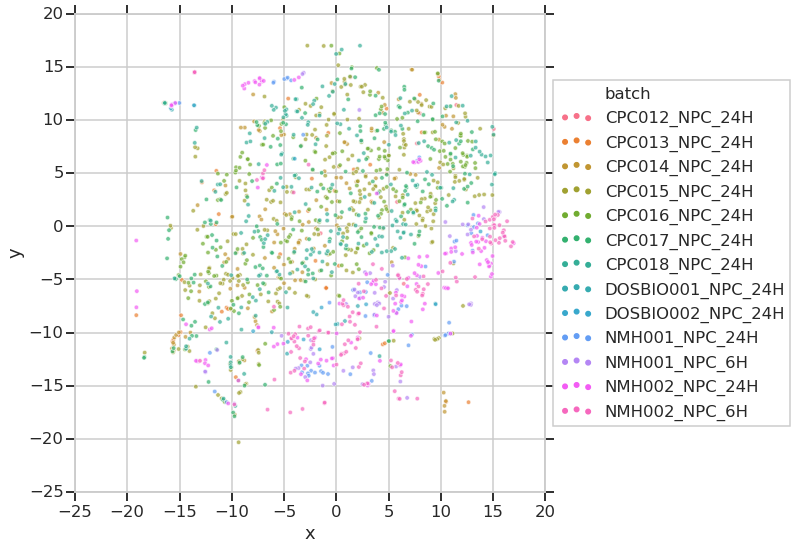

In [62]:
fig = plots.scatter_plot(sig_mat_tsne, sig_info_df_known_drugs, hue='batch')

In [63]:
sig_info_df_known_drugs.head()

,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id,batch,n_distil_ids
sig_id,,,,,,,,,,,,,
CPC012_NPC_24H:BRD-K00656370-001-01-4:10,BRD-K00656370,6-aminochrysene,trt_cp,NPC,10,µM,10 µM,24,h,24 h,CPC012_NPC_24H_X1_B7_DUO52HI53LO:L18|CPC012_NP...,CPC012_NPC_24H,3
CPC012_NPC_24H:BRD-K02130563-001-06-4:10,BRD-K02130563,panobinostat,trt_cp,NPC,10,µM,10 µM,24,h,24 h,CPC012_NPC_24H_X1_B7_DUO52HI53LO:E10|CPC012_NP...,CPC012_NPC_24H,3
CPC012_NPC_24H:BRD-K13810148-001-02-1:10,BRD-K13810148,givinostat,trt_cp,NPC,10,µM,10 µM,24,h,24 h,CPC012_NPC_24H_X1_B7_DUO52HI53LO:C07|CPC012_NP...,CPC012_NPC_24H,3
CPC012_NPC_24H:BRD-K26818574-001-03-0:10,BRD-K26818574,BIX-01294,trt_cp,NPC,10,µM,10 µM,24,h,24 h,CPC012_NPC_24H_X1_B7_DUO52HI53LO:G05|CPC012_NP...,CPC012_NPC_24H,3
CPC012_NPC_24H:BRD-K47761761-050-04-5:10,BRD-K47761761,PD-168077,trt_cp,NPC,10,µM,10 µM,24,h,24 h,CPC012_NPC_24H_X1_B7_DUO52HI53LO:O12|CPC012_NP...,CPC012_NPC_24H,3


In [64]:
sig_info_df_known_drugs = sig_info_df_known_drugs.merge(drug_moa_df, 
                                                        left_on='pert_id', 
                                                        right_index=True, 
                                                        how='left')

In [66]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')

In [75]:
frequent_MOAs = set(sig_info_df_known_drugs['MOA'].value_counts()[:19].index)
sig_info_df_known_drugs['MOA_frequent'] = [moa if moa in frequent_MOAs else 'other' \
                                           for moa in sig_info_df_known_drugs['MOA']]

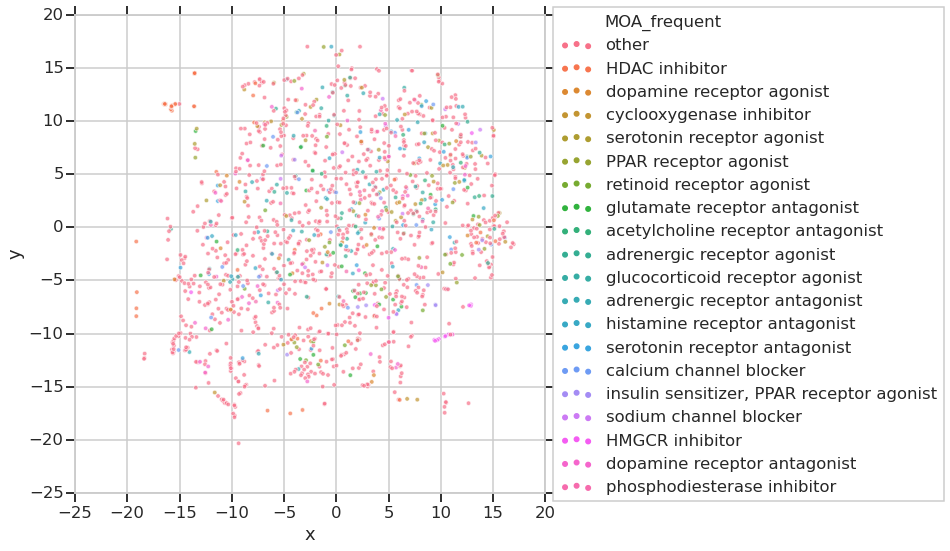

In [76]:
fig = plots.scatter_plot(sig_mat_tsne, sig_info_df_known_drugs, hue='MOA_frequent')

In [78]:
import umap

In [80]:
dir(umap)

['__builtins__', '__doc__', '__file__', '__name__', '__package__', '__path__']

In [ ]:
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)
